In [7]:
import sys
import os
!{sys.executable} -m pip install -r requirements.txt

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [8]:
import kagglehub
import cv2
import matplotlib.pyplot as plt

In [33]:
path = kagglehub.dataset_download("joosthazelzet/lego-brick-images")
IMG_DIR = path + "/LEGO brick images v1/2357 Brick corner 1x2x2/"

In [34]:
files = os.listdir(IMG_DIR)
# list all files within IMG_DIR
files

['201706171206-0258.png',
 '201706171206-0264.png',
 '201706171206-0270.png',
 '201706171206-0099.png',
 '201706171206-0066.png',
 '201706171206-0072.png',
 '201706171206-0112.png',
 '201706171206-0106.png',
 '201706171206-0338.png',
 '201706171206-0310.png',
 '201706171206-0304.png',
 '201706171206-0305.png',
 '201706171206-0311.png',
 '201706171206-0339.png',
 '201706171206-0107.png',
 '201706171206-0113.png',
 '201706171206-0073.png',
 '201706171206-0067.png',
 '201706171206-0098.png',
 '201706171206-0271.png',
 '201706171206-0265.png',
 '201706171206-0259.png',
 '201706171206-0298.png',
 '201706171206-0273.png',
 '201706171206-0267.png',
 '201706171206-0059.png',
 '201706171206-0071.png',
 '201706171206-0065.png',
 '201706171206-0139.png',
 '201706171206-0105.png',
 '201706171206-0111.png',
 '201706171206-0307.png',
 '201706171206-0313.png',
 '201706171206-0312.png',
 '201706171206-0306.png',
 '201706171206-0110.png',
 '201706171206-0104.png',
 '201706171206-0138.png',
 '2017061712

In [106]:
def find_edges(img):
    gray_img = img
    img_blur = img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(gray_img, (3,3), 0)
    edge_img = cv2.Canny(img,100,200)
    edge_img = cv2.cvtColor(edge_img, cv2.COLOR_GRAY2BGR)
    return gray_img, img_blur, edge_img

In [111]:
img = cv2.imread("/Users/anvay-coder/scan-cv/document_2_1752701338803.jpg")
gray_img, img_blur, edge_img = find_edges(img)

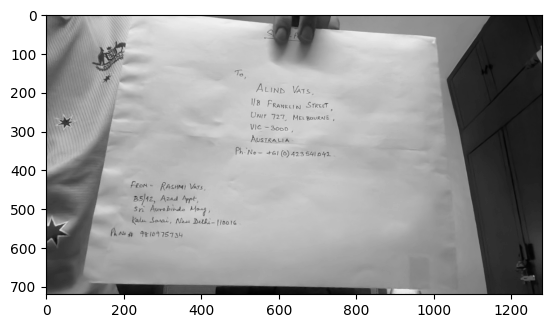

In [112]:
plt.imsave("img_gray.png", gray_img)
plt.imshow(gray_img, cmap='gray')

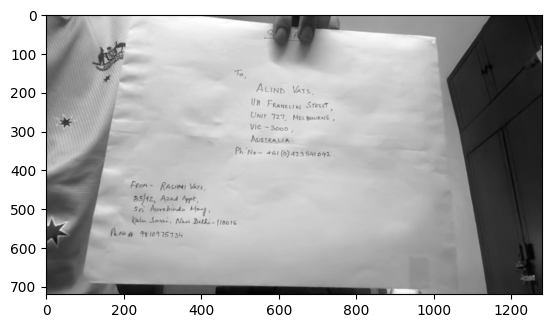

In [113]:
plt.imsave("img_blur.png", img_blur)
plt.imshow(img_blur, cmap='gray')

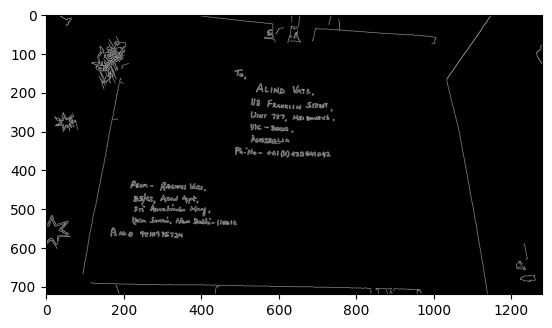

In [114]:
plt.imsave("img_edge.png", edge_img)
plt.imshow(edge_img, cmap='gray')

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def document_scanner(image, debug=False):
    """
    Document scanner that detects paper corners within the image.
    
    Args:
        image: Input color image containing a document
        debug: If True, shows intermediate processing steps
        
    Returns:
        Tuple of (original, corners_visualization, scanned_document)
    """
    original = image.copy()
    h, w = image.shape[:2]
    
    # Resize for processing if too large
    if h > 1000:
        scale = 1000 / h
        image = cv2.resize(image, None, fx=scale, fy=scale)
        h, w = image.shape[:2]
    
    # STEP 1: Preprocessing to enhance document edges
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply bilateral filter to reduce noise while preserving edges
    filtered = cv2.bilateralFilter(gray, 9, 75, 75)
    
    # STEP 2: Enhanced edge detection for document boundaries
    # Use adaptive threshold to handle varying lighting
    adaptive_thresh = cv2.adaptiveThreshold(
        filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 10
    )
    
    # Canny edge detection with optimized parameters
    edges = cv2.Canny(filtered, 30, 80, apertureSize=3)
    
    # Combine both edge detection methods
    combined_edges = cv2.bitwise_or(edges, adaptive_thresh)
    
    # Morphological operations to connect nearby edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    combined_edges = cv2.morphologyEx(combined_edges, cv2.MORPH_CLOSE, kernel)
    combined_edges = cv2.dilate(combined_edges, kernel, iterations=1)
    
    # STEP 3: Find document contour
    contours, _ = cv2.findContours(combined_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    document_contour = None
    
    # Look for the largest rectangular contour (the document)
    for contour in contours:
        # Calculate contour area
        area = cv2.contourArea(contour)
        
        # Skip very small contours (noise)
        if area < w * h * 0.01:
            continue
            
        # Approximate contour to polygon
        perimeter = cv2.arcLength(contour, True)
        epsilon = 0.02 * perimeter
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Look for quadrilateral (4 corners)
        if len(approx) == 4:
            # Check if it's a reasonable size (not too small, not the entire image)
            if w * h * 0.05 < area < w * h * 0.95:
                document_contour = approx
                break
    
    # If no good 4-corner contour found, try with more relaxed parameters
    if document_contour is None:
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < w * h * 0.01:
                continue
                
            perimeter = cv2.arcLength(contour, True)
            epsilon = 0.05 * perimeter  # More relaxed approximation
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            if len(approx) == 4 and w * h * 0.02 < area < w * h * 0.98:
                document_contour = approx
                break
    
    # Last fallback: use the largest contour and get its bounding rectangle
    if document_contour is None and len(contours) > 0:
        largest_contour = contours[0]
        rect = cv2.minAreaRect(largest_contour)
        document_contour = np.int32(cv2.boxPoints(rect))
    
    # Ultimate fallback: use entire image (but this shouldn't happen with real documents)
    if document_contour is None:
        document_contour = np.array([[50, 50], [w-50, 50], [w-50, h-50], [50, h-50]], dtype=np.float32)
    
    # STEP 4: Extract and order corners
    corners = document_contour.reshape(4, 2).astype(np.float32)
    
    def order_corners(pts):
        """Order points: top-left, top-right, bottom-right, bottom-left"""
        rect = np.zeros((4, 2), dtype=np.float32)
        
        # Sum and difference of coordinates
        s = pts.sum(axis=1)
        diff = np.diff(pts, axis=1)
        
        rect[0] = pts[np.argmin(s)]      # Top-left (smallest sum)
        rect[2] = pts[np.argmax(s)]      # Bottom-right (largest sum)
        rect[1] = pts[np.argmin(diff)]   # Top-right (smallest diff)
        rect[3] = pts[np.argmax(diff)]   # Bottom-left (largest diff)
        
        return rect
    
    corners = order_corners(corners)
    
    # STEP 5: Calculate output dimensions
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    # Calculate width and height of output rectangle
    width_top = distance(corners[0], corners[1])
    width_bottom = distance(corners[3], corners[2])
    height_left = distance(corners[0], corners[3])
    height_right = distance(corners[1], corners[2])
    
    max_width = int(max(width_top, width_bottom))
    max_height = int(max(height_left, height_right))
    
    # STEP 6: Perspective transformation
    dst_corners = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]
    ], dtype=np.float32)
    
    # Get perspective transform matrix
    M = cv2.getPerspectiveTransform(corners, dst_corners)
    
    # Apply transformation to original image
    warped = cv2.warpPerspective(image, M, (max_width, max_height))
    
    # STEP 7: Enhance scanned document
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding for clean text
    scanned = cv2.adaptiveThreshold(
        warped_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 10
    )
    
    # STEP 8: Visualize corners and edges
    corners_viz = image.copy()
    
    # Draw detected corners with labels
    corner_labels = ['TL', 'TR', 'BR', 'BL']
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, (corner, label, color) in enumerate(zip(corners, corner_labels, colors)):
        cv2.circle(corners_viz, tuple(corner.astype(int)), 10, color, -1)
        cv2.putText(corners_viz, label, (int(corner[0])+15, int(corner[1])-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    
    # Draw edges between corners
    for i in range(4):
        pt1 = tuple(corners[i].astype(int))
        pt2 = tuple(corners[(i + 1) % 4].astype(int))
        cv2.line(corners_viz, pt1, pt2, (0, 255, 255), 3)
    
    # Debug visualization
    if debug:
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 5, 1), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title('Original')
        plt.subplot(1, 5, 2), plt.imshow(filtered, cmap='gray'), plt.title('Filtered')
        plt.subplot(1, 5, 3), plt.imshow(combined_edges, cmap='gray'), plt.title('Combined Edges')
        plt.subplot(1, 5, 4), plt.imshow(cv2.cvtColor(corners_viz, cv2.COLOR_BGR2RGB)), plt.title('Document Corners')
        plt.subplot(1, 5, 5), plt.imshow(scanned, cmap='gray'), plt.title('Scanned Document')
        plt.tight_layout()
        plt.show()
    
    return original, corners_viz, scanned

# Test function
def test_scanner(image_path):
    """Test the document scanner"""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return
    
    original, corners_viz, scanned = document_scanner(image, debug=True)
    
    # Display final results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
    plt.subplot(1, 3, 2), plt.imshow(cv2.cvtColor(corners_viz, cv2.COLOR_BGR2RGB)), plt.title('Paper Corner Detection')
    plt.subplot(1, 3, 3), plt.imshow(scanned, cmap='gray'), plt.title('Scanned Paper')
    plt.tight_layout()
    plt.show()
    
    return original, corners_viz, scanned

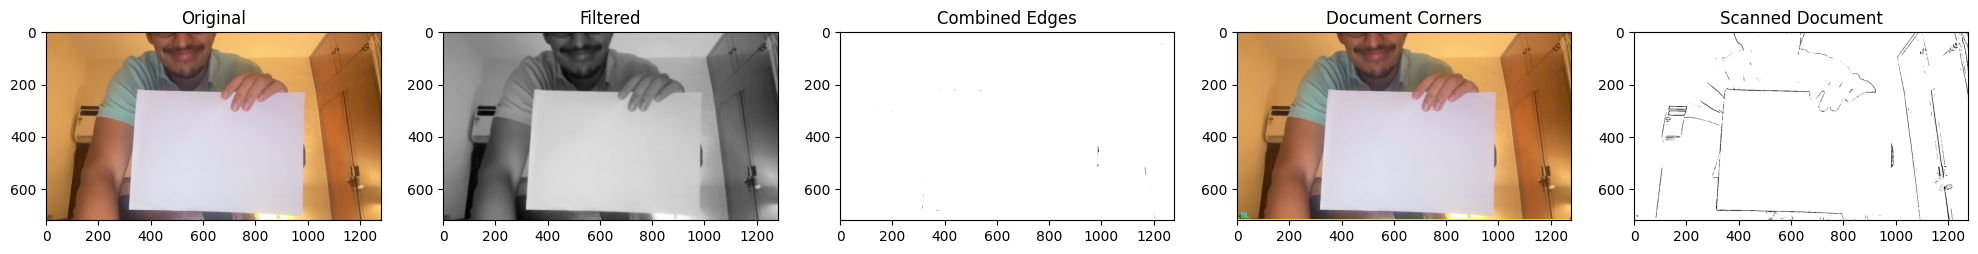

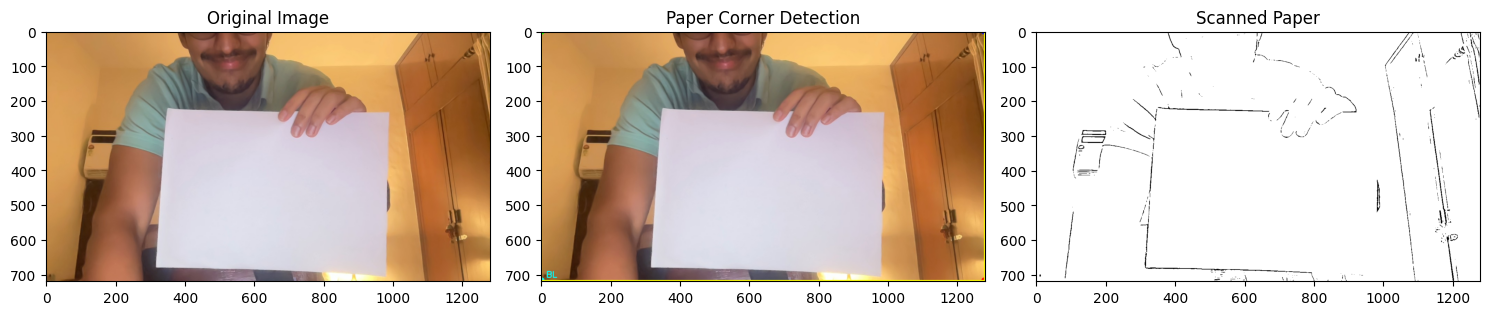

In [ ]:
# /Users/anvay-coder/document-scanner/document_1_1752773781461.jpg
# /Users/anvay-coder/document-scanner/document_2_1752773778776.jpg
img_path = "/Users/anvay-coder/document-scanner/document_1_1752773781461.jpg"
original, corners_viz, scanned = test_scanner(img_path)

In [11]:
cv2.imwrite("scanned_document.png", scanned)
cv2.imwrite("corners_visualization.png", corners_viz)

True